# iGas - Optimising Gas Lift Wells 
Authors: Peerapong Ekkawong, Rapheephan Laochamroonvorapongse & Nejhdeh Ghevondian

Optimisng and predicted Gas Lift Wells by time-series analysis of various features including the qgi & CIP



# Import libraries

In [1]:
%matplotlib inline

In [3]:

import numpy as np
import pandas as pd
import os
import re
from datetime import datetime
import time
import matplotlib.pyplot as plt

# smoothing functions
from statsmodels.nonparametric.smoothers_lowess import lowess

import statsmodels.api as sm
from scipy import stats

# datetime management (for minus days)

from datetime import timedelta

# <font color=blue>1. DATA READ SECTION</font> 
<font color=blue>#######################################</font>

All data reads, including SQL tables are performed here

## <font color=blue>1.1 Reading .csv file from each well</font> 

In [21]:


# set path
mypath = '..\\CSV'

# get the list of filenames
WellFileRaw_list = os.listdir(mypath)

# Regular expression for file format    
r = re.compile("[A-Z]{3}-.*csv") 

# Clean the file name based on given condition of S1's name format
WellFile_list = list(filter(r.match, WellFileRaw_list)) 

# Create WellName representing only name - removing .csv
WellName_list = [item[:-4] for item in WellFile_list] 

#%% Read filename and concat into single dataframe
print('Perform Reading .csv files')

# Summary record, Initialize Empty df only header
WellAll_df = pd.DataFrame(columns=['WellName','date','qgi','cip','thp','tht']) 


# loop through all .csv files & append to dataframe
for (i,File) in enumerate(WellFile_list):
    
    # to track the progress
    print('Reading ID = %d, FileName = %s' % (i,File)) 
    
    WellTemp_df = pd.read_csv(mypath + '\\' + File, header = 0)
    
    # Clean dataframe before concatenating, not contain 'No'
    
    CleanCriteria = ~ (WellTemp_df['qgi'].str.contains('No') |
                       WellTemp_df['cip'].str.contains('No') |
                       WellTemp_df['thp'].str.contains('No') |
                       WellTemp_df['tht'].str.contains('No')
                       )
    
    WellTemp_df = WellTemp_df[CleanCriteria] # Impose criteria for filtering
    
    # Convert datatype from object to numeric (float)
    WellTemp_df = WellTemp_df.astype({'qgi':'float','cip':'float','thp':'float','tht':'float'})
    
    # Convert datetype from object to datetime as per format
    WellTemp_df['date'] = pd.to_datetime(WellTemp_df['date'])#, format = '%m/%d/%Y %H:%M')
    
    WellTemp_df['WellName'] = WellName_list[i] # assign well name

    WellAll_df = pd.concat([WellAll_df, WellTemp_df], sort=False)




Perform Reading .csv files
Reading ID = 0, FileName = LKU-C42.csv
Reading ID = 1, FileName = LKU-CB01.csv
Reading ID = 2, FileName = LKU-CB08.csv
Reading ID = 3, FileName = LKU-CB13.csv
Reading ID = 4, FileName = LKU-CC01.csv
Reading ID = 5, FileName = LKU-G07.csv
Reading ID = 6, FileName = LKU-G09.csv
Reading ID = 7, FileName = LKU-L24.csv
Reading ID = 8, FileName = LKU-L32.csv
Reading ID = 9, FileName = LKU-L36.csv
Reading ID = 10, FileName = LKU-L42.csv
Reading ID = 11, FileName = LKU-R23.csv
Reading ID = 12, FileName = LKU-R25.csv
Reading ID = 13, FileName = LKU-T11.csv
Reading ID = 14, FileName = LKU-V28.csv
Reading ID = 15, FileName = LKU-W07.csv
Reading ID = 16, FileName = LKU-W16.csv
Reading ID = 17, FileName = LKU-W18.csv
Reading ID = 18, FileName = LKU-X23.csv
Reading ID = 19, FileName = LKU-X26.csv
Reading ID = 20, FileName = LKU-X27.csv
Reading ID = 21, FileName = LKU-Y09.csv
Reading ID = 22, FileName = LKU-Z27.csv
Reading ID = 23, FileName = LKU-Z38.csv
Reading ID = 24, Fi

In [25]:
# to check datatype
print(WellAll_df.dtypes)

# to check datatype
print(WellAll_df.shape)

# to review the dataframe
print(WellAll_df.head())

WellName            object
date        datetime64[ns]
qgi                float64
cip                float64
thp                float64
tht                float64
dtype: object
(2627911, 6)
  WellName                date        qgi         cip        thp        tht
0  LKU-C42 2018-01-08 16:02:00  35.248764  908.168990  96.711007  37.014889
1  LKU-C42 2018-01-08 16:05:00  35.137324  907.825799  96.690621  36.927277
2  LKU-C42 2018-01-08 16:08:00  35.092138  907.482608  96.670235  36.839664
3  LKU-C42 2018-01-08 16:11:00  35.080675  907.139418  96.649850  36.752444
4  LKU-C42 2018-01-08 16:14:00  35.069212  906.796227  96.629464  36.692073


## <font color=blue>1.2 Reading FGS_Summary_Batch1.csv</font> 

In [26]:
# set path

mypath = '..\\Target'

# read the file including the header
FGS_Summary_batch1 = pd.read_csv(mypath + '\\' + 'FGS_Summary_Batch1.csv', header = 0)

# assign uniform columns names to match the weel list names
FGS_Summary_batch1.columns = ['WellName','date','Category']

# Convert datetype from object to datetime as per format
FGS_Summary_batch1['date'] = pd.to_datetime(FGS_Summary_batch1['date'])

# use the category and set up label - We will use this for modelling purposes
FGS_Summary_batch1['Label'] = FGS_Summary_batch1['Category'].replace({'Suboptimal': 0, 'Normal': 1})

# check header
print(FGS_Summary_batch1.dtypes)

# check shape
print(FGS_Summary_batch1.shape)

# check head
print(FGS_Summary_batch1.head())
    

WellName            object
date        datetime64[ns]
Category            object
Label                int64
dtype: object
(34, 4)
   WellName       date    Category  Label
0  LKU-CB01 2018-06-16      Normal      1
1  LKU-CB08 2018-06-18  Suboptimal      0
2  LKU-CB13 2018-05-03      Normal      1
3   LKU-G07 2018-05-20  Suboptimal      0
4   LKU-G09 2018-05-28  Suboptimal      0


# <font color=blue>2. DATA PREPARATION SECTION</font> 
<font color=blue>#####################################################</font>


In [27]:
# check number of well
len(WellName_list)

32

In [28]:
Well_df = WellAll_df[WellAll_df['WellName'] == WellName_list[0]]
Well_df.head()

,WellName,date,qgi,cip,thp,tht
0,LKU-C42,2018-01-08 16:02:00,35.248764,908.168990,96.711007,37.014889
1,LKU-C42,2018-01-08 16:05:00,35.137324,907.825799,96.690621,36.927277
2,LKU-C42,2018-01-08 16:08:00,35.092138,907.482608,96.670235,36.839664
3,LKU-C42,2018-01-08 16:11:00,35.080675,907.139418,96.649850,36.752444
4,LKU-C42,2018-01-08 16:14:00,35.069212,906.796227,96.629464,36.692073


In [29]:
# Example of how to get dt.time and dt.date

# Well_df['date'].dt.time # to extract time part from the datetime
# Well_df['date'].dt.date # to extract time part from the datetime

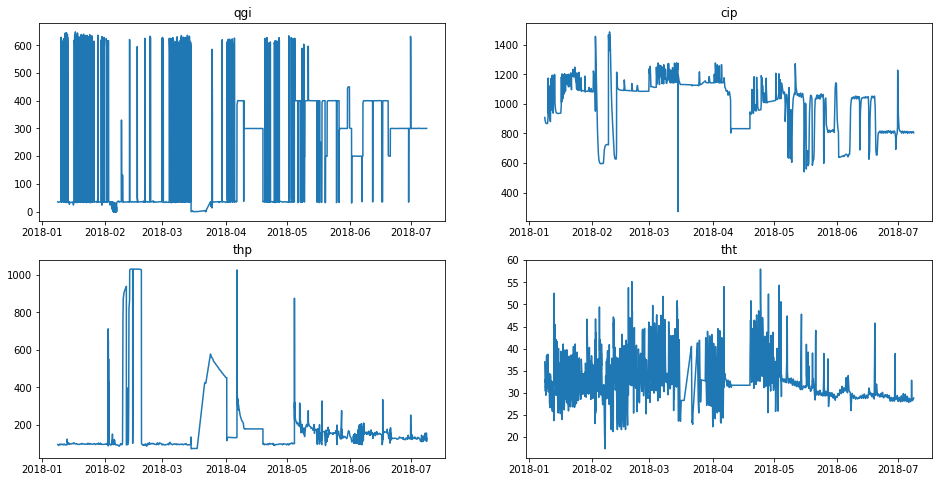

In [30]:
# Perform a sample plot
#######################


# get the first well
Well_df = WellAll_df[WellAll_df['WellName'] == WellName_list[0]]

sample_well = Well_df

# To visualize only the first date (anyways it's too short)
# sample_well = Well_df[Well_df['date'].dt.date == min(Well_df['date'].dt.date)] 



# set the size & plots as subplots
plt.figure(figsize=(16,8));

# qgi
plt.subplot(2,2,1)
plt.title(str(sample_well.columns[2]))
plt.plot(sample_well.date, sample_well.qgi)

# cip
plt.subplot(2,2,2)
plt.title(str(sample_well.columns[3]))
plt.plot(sample_well.date, sample_well.cip)

# thp
plt.subplot(2,2,3)
plt.title(str(sample_well.columns[4]))
plt.plot(sample_well.date, sample_well.thp)

# thp
plt.subplot(2,2,4)
plt.title(str(sample_well.columns[5]))
plt.plot(sample_well.date, sample_well.tht)


# <font color=blue>3. FEATURE ENGINEERING SECTION</font> 
<font color=blue>############################################################</font>

# <font color=blue> 3.1 Smoothing Functions</font>
Performing time-series smoothing functions on the features

Performed in 2 stages:
1. Per well across all available days
2. Per well for each daily basis

In [33]:
# Function to perform the LOWESS function smoothing
# LOWESS - locally-weighted polynomial regression
# this function resturns the original x values and the smoothed y values
# Reading theory: https://www.statisticshowto.datasciencecentral.com/lowess-smoothing/
# Reading doc: https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html


# import syntax
# from statsmodels.nonparametric.smoothers_lowess import lowess
# import statsmodels.api as sm



def lowess_smooth(x_value, y_value, fraction):
    # assign the values
    x = x_value
    y = y_value

    # lowess will return our "smoothed" data with a y value for at every x-value
    lowess = sm.nonparametric.lowess(y, x, frac = fraction)

    # unpack the lowess smoothed points to their values
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]

    return x, lowess_y

In [32]:
# Add Example of lowess_smooth, why not directly use the function


### <font color=blue> 3.1.1. Sample LOWESS on a single well across all days</font>


In [34]:

###################################################
# Eg: Well: 'LKU-C42' using CIP
# Estimated around 15 min

sample_well = WellAll_df[WellAll_df.WellName == 'LKU-C42'] # select sample dataframe

# assign the values
x = sample_well.date # pandas series
y = sample_well.cip  # pandas series





In [35]:
## [Nej]: to apply function and get the lowess_y

# call the lowess function
lowess_values = lowess_smooth(x, y, 0.2)
# obtain the smoothed y-values
lowess_y = lowess_values[1]

In [41]:
## Get from another smoothing value (0.1)

# call the lowess function and subset the result [1]
lowess_y_f01 = lowess_smooth(x, y, 0.1)[1]


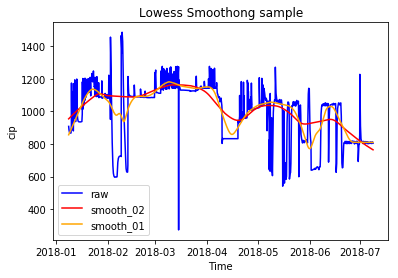

In [49]:
#lowess   = sm.nonparametric.lowess(y, x, frac = 0.2) 

# plot - plot the original and the smoothed
#plt.plot(x, y, 'blue', x, lowess_y, 'red')

plt.plot(x,            y, 'blue'   , label='raw')
plt.plot(x,     lowess_y, 'red'    , label='smooth_02')
plt.plot(x, lowess_y_f01, 'orange' , label='smooth_01')

plt.legend()
# lowess = sm.nonparametric.lowess(y, x, frac = 0.2) # [Peet] will return as numpy array
# plt.plot(x, y, 'blue', x, lowess[:,1], 'red') # [Peet] I think writing with build-in functin will be better

plt.xlabel('Time')
plt.ylabel('cip')
plt.title('Lowess Smoothong sample')
plt.show()

In [12]:
Well_df.head()

,WellName,date,qgi,cip,thp,tht
0,LKU-C42,2018-01-08 16:02:00,35.248764,908.168990,96.711007,37.014889
1,LKU-C42,2018-01-08 16:05:00,35.137324,907.825799,96.690621,36.927277
2,LKU-C42,2018-01-08 16:08:00,35.092138,907.482608,96.670235,36.839664
3,LKU-C42,2018-01-08 16:11:00,35.080675,907.139418,96.649850,36.752444
4,LKU-C42,2018-01-08 16:14:00,35.069212,906.796227,96.629464,36.692073


### <font color=blue> 3.1.2. Perform LOWESS based on well across all days</font>

### <font color=red> Caution: Long run time and this part of code not use in further calculation </font>

### <font color=red> Caution: Not use in further calculation </font>

In [ ]:
#################################################

lowess_perWell = []
lowess_total   = []
for WellName in WellName_list[0:2]: #loop wells
    print('Current well is' + WellName)
    # obtain the particular well
    Well_df = WellAll_df[WellAll_df['WellName'] == WellName]
  
    # loop through each paramter
    lowess_perParamters = []
    for i in range(4):
        print('Current column index is: ' + str(i))

        lowess_Paramter = lowess_smooth(Well_df.date, Well_df[Well_df.columns[i+2]], 0.2)

        # keep the date also embedded for checking
        lowess_perParamter = pd.DataFrame(np.transpose(np.array(lowess_Paramter)))

        # append at each loop
        lowess_perParamters.append(Well_df.WellName)
        lowess_perParamters.append(lowess_perParamter[0])
        lowess_perParamters.append(Well_df[Well_df.columns[i+2]])
        lowess_perParamters.append(lowess_perParamter[1])
        
     # append to dataframe
    lowess_perWell = pd.concat(lowess_perParamters, axis=1, ignore_index=True)
    lowess_total.append(lowess_perWell)

lowess_total

In [ ]:
# combine to all
lowess_all = pd.concat(lowess_total, ignore_index=True)  

# perform column cleansing and renaming
# drop extra columns & rename the new smoothed columns
lowess_all.drop(lowess_all.columns[[4,5,8,9,12,13]], axis=1, inplace=True)
lowess_all.columns = [str(WellAll_df.columns[0]),
                      str(WellAll_df.columns[1]),
                      str(WellAll_df.columns[2]),
                      str(WellAll_df.columns[2]) + '_lowess', 
                      str(WellAll_df.columns[3]),
                      str(WellAll_df.columns[3]) + '_lowess',
                      str(WellAll_df.columns[4]),
                      str(WellAll_df.columns[4]) + '_lowess',
                      str(WellAll_df.columns[5]),
                      str(WellAll_df.columns[5]) + '_lowess']

lowess_all

In [ ]:
# test with a plot
##################
# Take a sample Well (note: across all days)
sample_well = lowess_all[lowess_all.WellName == 'LKU-C42']

# assign the values
x = sample_well.date
y = sample_well.cip
lowess_y = sample_well.cip_lowess

# plot - plot the original and the smoothed
#plt.plot(x, y, 'blue', x, lowess_y, 'red')
plt.plot(x, lowess_y, 'blue')
plt.title('Lowess Smoothong sample from overall dataset')
plt.show()


### <font color=red> End of 3.1.2. Perform LOWESS based on well across all days </font>

### <font color=blue> 3.1.3. Perform LOWESS based on well **per day** basis </font>

Use this as main product **Caution Long run time !**

In [59]:
#################################################
# around 100s per well (1.5 min)
# for 32 wells --> 1 hr

lowess_perWell = []
lowess_total   = []

lowess_perParamters = []
for WellName in WellName_list:
    
    # Indicate status
    print('Analysing lowess for well: \n', WellName)
    
    # obtain the particular well
    Well_df = WellAll_df[WellAll_df['WellName'] == WellName]
    
    # obtain the unique date list
    Well_dates = Well_df['date'].dt.date.unique()
    
    # loop through each day
    for eachDate in Well_dates:
        print('Current Date is :')
        print(eachDate)
        Well_df_daily = Well_df[Well_df['date'].dt.date == eachDate]
        Well_df_daily.reset_index(drop = True, inplace = True)
        

        # loop through each paramter
        lowess_perParamters = []
        for i in range(4):
            print('Parameter :' + str(i))
            
            fraction = 0.1 # to be the same as R code
            lowess_Paramter = lowess_smooth(Well_df_daily.date, Well_df_daily[Well_df.columns[i+2]], fraction)

            # keep the date also embedded for checking
            lowess_perParamter = pd.DataFrame(np.transpose(np.array(lowess_Paramter)))

            # append at each loop
            lowess_perParamters.append(Well_df_daily.WellName) # well name
            lowess_perParamters.append(lowess_perParamter[0])  # X (Datetime)
            lowess_perParamters.append(Well_df_daily[Well_df_daily.columns[i+2]]) # Actual Y value
            lowess_perParamters.append(lowess_perParamter[1])  # Y value of lowess

         # append to dataframe
        lowess_perWell = pd.concat(lowess_perParamters, axis=1, ignore_index=True)
        lowess_total.append(lowess_perWell)

    # append to dataframe
    lowess_daily_all = pd.concat(lowess_total, ignore_index=True)  



Analysing lowess for well: 
 LKU-C42
Current Date is :
2018-01-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-19
Parameter :0
Parameter :1
Parameter :2
Para

Current Date is :
2018-04-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-04

Parameter :2
Parameter :3
Current Date is :
2018-01-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :3
Current Date is :
2018-05-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-06
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :3
Current Date is :
2018-06-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-01
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :2
Parameter :3
Current Date is :
2018-06-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Analysing lowess for well: 
 LKU-CC01
Current Date is :
2018-01-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-10
Parameter :0
Par

Parameter :2
Parameter :3
Current Date is :
2018-04-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :3
Current Date is :
2018-01-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Current Date is :
2018-05-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-18

Current Date is :
2018-02-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-26

Parameter :2
Parameter :3
Current Date is :
2018-05-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :2
Parameter :3
Current Date is :
2018-03-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Current Date is :
2018-06-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-04

Current Date is :
2018-04-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-17

Current Date is :
2018-01-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-26

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-10
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :2
Parameter :3
Current Date is :
2018-02-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :3
Current Date is :
2018-05-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :2
Parameter :3
Current Date is :
2018-03-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

C:\Users\PeerapongE\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)



Current Date is :
2018-03-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-0

Parameter :2
Parameter :3
Current Date is :
2018-07-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Analysing lowess for well: 
 LKU-R25
Current Date is :
2018-01-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-14
Parameter :0
Para

Parameter :2
Parameter :3
Current Date is :
2018-04-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :2
Parameter :3
Current Date is :
2018-01-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Current Date is :
2018-05-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-24

Parameter :3
Current Date is :
2018-02-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-16
Parameter :0
Parameter :1
Pa

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-30
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :2
Parameter :3
Current Date is :
2018-06-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Analysing lowess for well: 
 LKU-W16
Current Date is :
2018-01-08
Parameter :0
Para

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-22
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-31
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :3
Current Date is :
2018-05-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-03
Parameter :0
Parameter :1
Pa

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Analysing lowess for well: 
 LKU-X26
Current Date is :
2018-02-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-23
Para

Parameter :2
Parameter :3
Current Date is :
2018-05-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :2
Parameter :3
Current Date is :
2018-04-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :2
Parameter :3
Current Date is :
2018-02-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :3
Current Date is :
2018-05-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :2
Parameter :3
Current Date is :
2018-02-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :3
Current Date is :
2018-06-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-03
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :2
Parameter :3
Current Date is :
2018-07-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Analysing lowess for well: 
 LKU-Z44
Current Date is :
2018-01-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-12
Parameter :0
Para

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-26
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :2
Parameter :3
Current Date is :
2018-01-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Parameter :3
Current Date is :
2018-05-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Parameter :2
Parameter :3
Current Date is :
2018-02-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Current Date is :
2018-06-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-15

Current Date is :
2018-03-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-29

Parameter :2
Parameter :3
Current Date is :
2018-06-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-07-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
An

Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-04-21
Parameter :0
Parameter :1
Parameter :2
Pa

Parameter :2
Parameter :3
Current Date is :
2018-01-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-01-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Cu

Current Date is :
2018-05-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-14

Parameter :3
Current Date is :
2018-02-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-02-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Current Date is :
2018-05-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-29
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-30
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-05-31
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-01
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-02
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-03
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-04
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-06

Parameter :3
Current Date is :
2018-03-05
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-06
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-07
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-08
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-09
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-10
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-11
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-12
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-13
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-14
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-15
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-03-16
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is

Current Date is :
2018-06-17
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-18
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-19
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-20
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-21
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-22
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-23
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-24
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-25
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-26
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-27
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-28
Parameter :0
Parameter :1
Parameter :2
Parameter :3
Current Date is :
2018-06-29

In [61]:
lowess_daily_all.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,LKU-C42,2018-01-08 16:02:00,35.248764,35.1151,LKU-C42,2018-01-08 16:02:00,908.168990,908.169,LKU-C42,2018-01-08 16:02:00,96.711007,96.711,LKU-C42,2018-01-08 16:02:00,37.014889,36.8682
1,LKU-C42,2018-01-08 16:05:00,35.137324,35.1036,LKU-C42,2018-01-08 16:05:00,907.825799,907.826,LKU-C42,2018-01-08 16:05:00,96.690621,96.6906,LKU-C42,2018-01-08 16:05:00,36.927277,36.8242
2,LKU-C42,2018-01-08 16:08:00,35.092138,35.0921,LKU-C42,2018-01-08 16:08:00,907.482608,907.483,LKU-C42,2018-01-08 16:08:00,96.670235,96.6702,LKU-C42,2018-01-08 16:08:00,36.839664,36.7802
3,LKU-C42,2018-01-08 16:11:00,35.080675,35.0807,LKU-C42,2018-01-08 16:11:00,907.139418,907.139,LKU-C42,2018-01-08 16:11:00,96.649850,96.6498,LKU-C42,2018-01-08 16:11:00,36.752444,36.7361
4,LKU-C42,2018-01-08 16:14:00,35.069212,35.0692,LKU-C42,2018-01-08 16:14:00,906.796227,906.796,LKU-C42,2018-01-08 16:14:00,96.629464,96.6295,LKU-C42,2018-01-08 16:14:00,36.692073,36.6921


In [62]:
lowess_daily_all.shape

(2627911, 16)

In [63]:
    
# perform column cleansing and renaming
# drop extra columns & rename the new smoothed columns
lowess_daily_all.drop(lowess_daily_all.columns[[4,5,8,9,12,13]], axis=1, inplace=True) # drop wellname and datetime (4-5, 8-9, 12-13)
lowess_daily_all.columns = [str(WellAll_df.columns[0]), # wellname
                            str(WellAll_df.columns[1]), # date
                            str(WellAll_df.columns[2]), # qgi
                            str(WellAll_df.columns[2]) + '_lowess', #qgi_lowess
                            str(WellAll_df.columns[3]), # cip
                            str(WellAll_df.columns[3]) + '_lowess', # cip_lowess
                            str(WellAll_df.columns[4]), # thp
                            str(WellAll_df.columns[4]) + '_lowess', # thp_lowess
                            str(WellAll_df.columns[5]), # tht
                            str(WellAll_df.columns[5]) + '_lowess'] # tht_lowess

lowess_daily_all.head()

,WellName,date,qgi,qgi_lowess,cip,cip_lowess,thp,thp_lowess,tht,tht_lowess
0,LKU-C42,2018-01-08 16:02:00,35.248764,35.1151,908.168990,908.169,96.711007,96.711,37.014889,36.8682
1,LKU-C42,2018-01-08 16:05:00,35.137324,35.1036,907.825799,907.826,96.690621,96.6906,36.927277,36.8242
2,LKU-C42,2018-01-08 16:08:00,35.092138,35.0921,907.482608,907.483,96.670235,96.6702,36.839664,36.7802
3,LKU-C42,2018-01-08 16:11:00,35.080675,35.0807,907.139418,907.139,96.649850,96.6498,36.752444,36.7361
4,LKU-C42,2018-01-08 16:14:00,35.069212,35.0692,906.796227,906.796,96.629464,96.6295,36.692073,36.6921


In [64]:
# also write results to output file
lowess_daily_all.to_csv('iGas_smooth.csv', header=True, index=True)


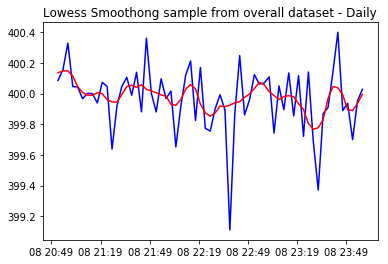

In [112]:
# Original dataframe - test dataframe with a plot
# particualr well
sample = WellAll_df[(WellAll_df['WellName'] == 'LKU-CB01')] # query by name

#obtain a date
Well_dates = sample['date'].dt.date.unique()
sample = sample[sample.date.dt.date == Well_dates[0]] # query by name --> date

# apply the smoothing function
sample_smooth = lowess_smooth(sample.date, sample.qgi, 0.1) 

# obtain the results
lowess_y = sample_smooth[1]

# plot - plot the original and the smoothed
plt.plot(sample.date, sample.qgi, 'blue', sample.date, lowess_y, 'red')
plt.title('Lowess Smoothong sample from overall dataset - Daily')
plt.show()


# The smoothe dataset - test a sample well for a sample day

sample_daily = lowess_daily_all[lowess_daily_all['WellName'] == 'LKU-CB01']  # Query by wellname

#obtain a date
Well_dates = sample_daily['date'].dt.date.unique()
sample_daily = sample_daily[sample_daily.date.dt.date == Well_dates[0]] # query by wellname --> firstdate


# use the already smoothd dataset to obtain the results
x = sample_daily.date
y = sample_daily.qgi
lowess_y = sample_daily.qgi_lowess # just call the result


# plot - plot the original and the smoothed
plt.plot(x, y, 'blue', x, lowess_y, 'red')
plt.title('Lowess Smoothong sample from overall dataset - Daily smooth dataset')
plt.show()

# <font color=blue> 3.2 Statistical Calculations</font>
Performing time-series statistical analysis for fluctuations on the features 
This uses the output from the LOWESS smoothed functions

In [72]:
lowess_daily_all.head()

,WellName,date,qgi,qgi_lowess,cip,cip_lowess,thp,thp_lowess,tht,tht_lowess
0,LKU-C42,2018-01-08 16:02:00,35.248764,35.1151,908.168990,908.169,96.711007,96.711,37.014889,36.8682
1,LKU-C42,2018-01-08 16:05:00,35.137324,35.1036,907.825799,907.826,96.690621,96.6906,36.927277,36.8242
2,LKU-C42,2018-01-08 16:08:00,35.092138,35.0921,907.482608,907.483,96.670235,96.6702,36.839664,36.7802
3,LKU-C42,2018-01-08 16:11:00,35.080675,35.0807,907.139418,907.139,96.649850,96.6498,36.752444,36.7361
4,LKU-C42,2018-01-08 16:14:00,35.069212,35.0692,906.796227,906.796,96.629464,96.6295,36.692073,36.6921


In [96]:
Well_df = lowess_daily_all[lowess_daily_all['WellName'] == WellName]
Well_df.head()

,WellName,date,qgi,qgi_lowess,cip,cip_lowess,thp,thp_lowess,tht,tht_lowess
2543862,TYI-A03,2018-01-08 16:56:00,0.0,0,1377.181323,1377.18,119.225754,119.226,37.929956,37.93
2543863,TYI-A03,2018-01-08 16:59:00,0.0,0,1376.966036,1376.97,119.172924,119.173,37.858555,37.8586
2543864,TYI-A03,2018-01-08 17:02:00,0.0,0,1376.750749,1376.75,119.120094,119.12,37.787154,37.7872
2543865,TYI-A03,2018-01-08 17:05:00,0.0,0,1376.535462,1376.54,119.067264,119.067,37.715753,37.7158
2543866,TYI-A03,2018-01-08 17:08:00,0.0,0,1376.320175,1376.32,119.014434,119.014,37.644351,37.6444


In [117]:
# 3. Perform time-series calculations based on well per day basis 
#################################################################

timer = time.time()

calculations_perWellDay = []

for WellName in WellName_list: # Loop all wells
    print('elapse time = %.2f'% ( timer - time.time() ))
    
    # obtain the particular well
    Well_df = lowess_daily_all[lowess_daily_all['WellName'] == WellName]
    
    # Indicate status
    print('Analysing lowess for well: \n', WellName)
    
    
    # obtain the unique date list for particular well
    Well_dates = Well_df['date'].dt.date.unique()
    
    # loop through each day
    for eachDate in Well_dates: # Loop all days in particular well
        # 1 day (today)
        # eachDate
        Well_df_daily = Well_df[Well_df['date'].dt.date == eachDate]
        Well_df_daily.reset_index(drop = True, inplace = True)
        
        # 7 days ago
        last07day = eachDate - timedelta(days = 7)
        Well_df_last07 = Well_df[(Well_df['date'].dt.date <= eachDate) & (Well_df['date'].dt.date >= last07day)]
        Well_df_last07.reset_index(drop = True, inplace = True)
        
        # 14 days ago
        last14day = eachDate - timedelta(days = 14)        
        Well_df_last14 = Well_df[(Well_df['date'].dt.date <= eachDate) & (Well_df['date'].dt.date >= last14day)]
        Well_df_last14.reset_index(drop = True, inplace = True)
        
        # loop through each paramter
        calculations_perParamters = []
       
        calculations_perParamters.append(WellName)
        calculations_perParamters.append(eachDate)
        for i in range(4): # Loop wellname -> daily -> all parameters
            
            # calc the mean of each parameter daily
            
            mean_Paramter  = Well_df_daily[Well_df_daily.columns[2*i+3]].mean() # mean of particular well, parameter in each day
            sd_Paramter    = Well_df_daily[Well_df_daily.columns[2*i+3]].std()  # standard deviation
            max_Paramter   = Well_df_daily[Well_df_daily.columns[2*i+3]].max()  # maximum
            min_Paramter   = Well_df_daily[Well_df_daily.columns[2*i+3]].min()  # minimum
            range_Paramter = np.abs(max_Paramter - min_Paramter) 
            power_Paramter = Well_df_daily[Well_df_daily.columns[2*i+3]].sum() # summation 
            
            # append at each loop
            calculations_perParamters.append(mean_Paramter)
            calculations_perParamters.append(sd_Paramter)
            calculations_perParamters.append(max_Paramter)
            calculations_perParamters.append(min_Paramter)
            calculations_perParamters.append(range_Paramter)
            calculations_perParamters.append(power_Paramter)
            
        
        # also perform the lineare regression to get r2 parametes
        # 1 day
        (gradient , intercept , r_value , p_value , std_err)                = stats.linregress(Well_df_daily.cip  , Well_df_daily.qgi)
        
        # 7 day
        (gradient_07 , intercept_07 , r_value_07 , p_value_07 , std_err_07) = stats.linregress(Well_df_last07.cip , Well_df_last07.qgi)
        
        # 14 day
        (gradient_14 , intercept_14 , r_value_14 , p_value_14 , std_err_14) = stats.linregress(Well_df_last14.cip , Well_df_last14.qgi)


        # calc_correlation_results
        calculations_perParamters.append(gradient)
        calculations_perParamters.append(r_value**2)
        calculations_perParamters.append(p_value)
        
        # calc_correlation_results:  7 day
        calculations_perParamters.append(gradient_07)
        calculations_perParamters.append(r_value_07**2)
        calculations_perParamters.append(p_value_07)        
        
        
        
        # calc_correlation_results: 14 day
        calculations_perParamters.append(gradient_14)
        calculations_perParamters.append(r_value_14**2)
        calculations_perParamters.append(p_value_14)        
        
        

        # transpoe at each new date
        calculations_perWellDay.append(np.transpose(calculations_perParamters))

# convert to dataframe
calculations_perWellDay = pd.DataFrame(calculations_perWellDay)
calculations_perWellDay.reset_index(drop = True, inplace = True)
        
# rename the dataframes    
calculations_perWellDay.columns = [str(WellAll_df.columns[0]),
                                str(WellAll_df.columns[1]),
                                
                                str(WellAll_df.columns[2]) + '_mean', 
                                str(WellAll_df.columns[2]) + '_std',
                                str(WellAll_df.columns[2]) + '_max',
                                str(WellAll_df.columns[2]) + '_min',
                                str(WellAll_df.columns[2]) + '_range',
                                str(WellAll_df.columns[2]) + '_power',
                                
                                str(WellAll_df.columns[3]) + '_mean', 
                                str(WellAll_df.columns[3]) + '_std',
                                str(WellAll_df.columns[3]) + '_max',
                                str(WellAll_df.columns[3]) + '_min',
                                str(WellAll_df.columns[3]) + '_range',
                                str(WellAll_df.columns[3]) + '_power',
                                
                                str(WellAll_df.columns[4]) + '_mean', 
                                str(WellAll_df.columns[4]) + '_std',
                                str(WellAll_df.columns[4]) + '_max',
                                str(WellAll_df.columns[4]) + '_min',
                                str(WellAll_df.columns[4]) + '_range',
                                str(WellAll_df.columns[4]) + '_power',
                                
                                str(WellAll_df.columns[5]) + '_mean', 
                                str(WellAll_df.columns[5]) + '_std',
                                str(WellAll_df.columns[5]) + '_max',
                                str(WellAll_df.columns[5]) + '_min',
                                str(WellAll_df.columns[5]) + '_range',
                                str(WellAll_df.columns[5]) + '_power',
                               
                                'cip_qgi_gradient',
                                'cip_qgi_r2',
                                'cip_qgi_pValue',
                                   
                                'cip_qgi_07day_gradient',
                                'cip_qgi_07day_r2',
                                'cip_qgi_07day_pValue',                                  

                                'cip_qgi_14day_gradient',
                                'cip_qgi_14day_r2',
                                'cip_qgi_14day_pValue'                                
                                  
                                  
                                ]


calculations_perWellDay.head()

elapse time = -0.00
Analysing lowess for well: 
 LKU-C42


C:\Users\PeerapongE\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\PeerapongE\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


elapse time = -61.06
Analysing lowess for well: 
 LKU-CB01
elapse time = -127.84
Analysing lowess for well: 
 LKU-CB08
elapse time = -194.59
Analysing lowess for well: 
 LKU-CB13
elapse time = -262.61
Analysing lowess for well: 
 LKU-CC01
elapse time = -325.56
Analysing lowess for well: 
 LKU-G07


C:\Users\PeerapongE\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


elapse time = -388.68
Analysing lowess for well: 
 LKU-G09
elapse time = -456.02
Analysing lowess for well: 
 LKU-L24
elapse time = -516.37
Analysing lowess for well: 
 LKU-L32
elapse time = -584.36
Analysing lowess for well: 
 LKU-L36
elapse time = -647.82
Analysing lowess for well: 
 LKU-L42
elapse time = -707.69
Analysing lowess for well: 
 LKU-R23


C:\Users\PeerapongE\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\PeerapongE\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\PeerapongE\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\PeerapongE\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


elapse time = -768.52
Analysing lowess for well: 
 LKU-R25
elapse time = -828.79
Analysing lowess for well: 
 LKU-T11
elapse time = -887.64
Analysing lowess for well: 
 LKU-V28
elapse time = -952.61
Analysing lowess for well: 
 LKU-W07
elapse time = -1013.04
Analysing lowess for well: 
 LKU-W16
elapse time = -1073.16
Analysing lowess for well: 
 LKU-W18
elapse time = -1133.26
Analysing lowess for well: 
 LKU-X23
elapse time = -1172.94
Analysing lowess for well: 
 LKU-X26
elapse time = -1209.28
Analysing lowess for well: 
 LKU-X27
elapse time = -1246.72
Analysing lowess for well: 
 LKU-Y09
elapse time = -1305.91
Analysing lowess for well: 
 LKU-Z27
elapse time = -1365.75
Analysing lowess for well: 
 LKU-Z38
elapse time = -1427.10
Analysing lowess for well: 
 LKU-Z44
elapse time = -1501.07
Analysing lowess for well: 
 LKU-ZD07
elapse time = -1565.15
Analysing lowess for well: 
 LKU-ZD35
elapse time = -1629.31
Analysing lowess for well: 
 NMM-C06
elapse time = -1697.54
Analysing lowess fo

,WellName,date,qgi_mean,qgi_std,qgi_max,qgi_min,qgi_range,qgi_power,cip_mean,cip_std,...,tht_power,cip_qgi_gradient,cip_qgi_r2,cip_qgi_pValue,cip_qgi_07day_gradient,cip_qgi_07day_r2,cip_qgi_07day_pValue,cip_qgi_14day_gradient,cip_qgi_14day_r2,cip_qgi_14day_pValue
0,LKU-C42,2018-01-08,34.203760,0.531102,35.115063,33.292457,1.822607,5472.601614,890.154034,8.108856,...,5398.994167,0.064756,0.970915,2.741864e-123,0.064756,0.970915,2.741864e-123,0.064756,0.970915,2.741864e-123
1,LKU-C42,2018-01-09,34.519559,0.742649,35.300000,33.306334,1.993666,16569.388410,868.608539,2.474481,...,17206.959764,-0.243721,0.658911,1.017129e-113,-0.012334,0.032696,4.154806e-06,-0.012334,0.032696,4.154806e-06
2,LKU-C42,2018-01-10,133.260617,214.505458,629.054047,35.328939,593.725108,63965.096150,962.465891,71.367971,...,15811.033555,1.208141,0.204949,1.250712e-25,1.151931,0.286750,4.074989e-84,1.151931,0.286750,4.074989e-84
3,LKU-C42,2018-01-11,128.379786,210.596448,624.379614,34.558502,589.821112,61622.297117,963.231079,90.757462,...,14525.109916,1.394534,0.357120,8.453105e-48,1.237372,0.329895,4.252044e-141,1.237372,0.329895,4.252044e-141
4,LKU-C42,2018-01-12,117.313962,199.765189,705.445629,33.706209,671.739421,56310.701836,1012.349934,65.072532,...,13535.828439,2.031649,0.340670,3.628339e-45,1.336832,0.339873,1.175147e-189,1.336832,0.339873,1.175147e-189


# <font color=blue> 3.4 Examples & Visual Inspections section</font>
This section runs some examples of wells for testing and visual validation for some of the functions above

### <font color=red> Need this part before 3.3 since some modules from this section are prerequisite for the 3.3</font>

### <font color=blue> 3.4.1 Examples 1</font>

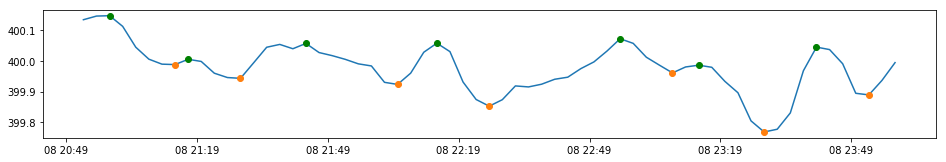

In [118]:
###########

# uses a sample well to run some of the fourier functions

from scipy.signal import argrelmax
from scipy.signal import argrelextrema
# Calculate the relative extrema of data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html

from scipy.signal import chirp, find_peaks, peak_widths
from scipy.signal import find_peaks, peak_prominences

sample_daily = lowess_daily_all[lowess_daily_all['WellName'] == 'LKU-CB01']

#obtain a date
Well_dates = sample_daily['date'].dt.date.unique()
sample_daily = sample_daily[sample_daily.date.dt.date == Well_dates[0]]

# set up the data sets
x = np.array(sample_daily['date']) # date
y = np.array(sample_daily.qgi_lowess) #smoothen qgi

# Perform local maximums
localMaxs_index = argrelextrema(y, np.greater, order=2)
localMins_index = argrelextrema(y, np.less, order=2) 

# convert to list
localMaxs_index = [a for b in localMaxs_index for a in b]
localMins_index = [a for b in localMins_index for a in b]

# obtain the values also
localMaxs_values = y[localMaxs_index]
localMins_values = y[localMins_index]

# set the size & plots as subplots
plt.figure(figsize=(16,8))

# plot - plot the smoothed data and the peaks
plt.subplot(3,1,1)
plt.plot(sample_daily.date, sample_daily.qgi_lowess)
plt.plot(x[localMaxs_index], localMaxs_values, 'o', color='green')
plt.plot(x[localMins_index], localMins_values, 'o',)
plt.show()

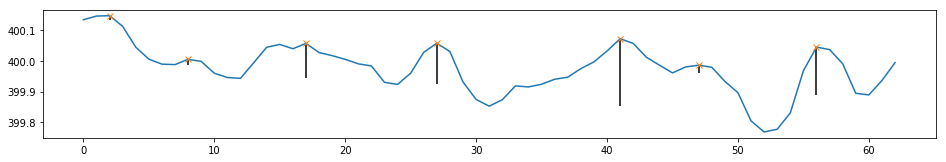

In [119]:
# 2. Peak height sample
#######################
# find prominant peaks
prominences = peak_prominences(y, localMaxs_index)[0]
contour_heights = y[localMaxs_index] - prominences


plt.figure(figsize=(16,8))
plt.subplot(3,1,2)
plt.plot(y)
plt.plot(localMaxs_index, y[localMaxs_index], "x")
plt.vlines(x=localMaxs_index, ymin=contour_heights, ymax=y[localMaxs_index]) # Draw vertical line
plt.show()


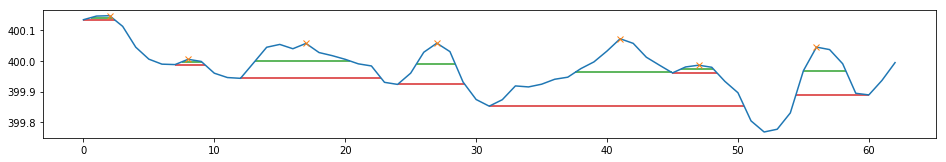

In [120]:
# 3. Peak width sample
#####################
results_half = peak_widths(y, localMaxs_index, rel_height=0.5)
results_half[0]  # widths

results_full = peak_widths(y, localMaxs_index, rel_height=1)
results_full[0]  # widths

plt.figure(figsize=(16,8))
plt.subplot(3,1,3)
plt.plot(y)
plt.plot(localMaxs_index, y[localMaxs_index], "x")
plt.hlines(*results_half[1:], color="C2") # draw horizontal line
plt.hlines(*results_full[1:], color="C3") # draw horizontal line
plt.show()

### <font color=blue> 3.4.2 Examples 2  - Calling the local_max_min function</font>

In [121]:
# function to calcuate the fluctuation characteristics (amplitude) of each feature
# returns the number of local maximums & minimums 
# & classification of these local max & mins based on a average value

def local_max_min(x_value, y_value, signal_width):
    
    # setting fluctuation (amplitude) thresholds
    THRESH_UPPER = 1.1
    THRESH_LOWER = 1.05
    
    # assign the values - must convert in array
    x = np.array(x_value)
    y = np.array(y_value)
    
    #print(y)

    # Perform local maximums & minimums
    localMaxs_index = argrelextrema(y, np.greater, order=signal_width)
    localMins_index = argrelextrema(y, np.less, order=signal_width) 

    
    # convert to list
    localMaxs_index = [a for b in localMaxs_index for a in b]
    localMins_index = [a for b in localMins_index for a in b]

    # check to see if not empty
    ###########################
    if((len(localMaxs_index) == 0) | (len(localMins_index) == 0)):
        return (0,0,0,0,0)
    else:
    
        #get the number of maximums & minimums (peaks and troughs)
        localMaxs_total = len(localMaxs_index)
        localMins_total = len(localMins_index)

        # combine the max and min indexs and sort them
        # this will allow sequential max and mins
        locaMaxsMins_index = np.sort(localMaxs_index + localMins_index)
        
        # obtain the values 
        localMaxs_values = list(y[localMaxs_index])
        localMins_values = list(y[localMins_index])

        # get teh actual values of max & mins in this sequence
        locaMaxsMins_values = list(y[locaMaxsMins_index])

        # get the diffrence between each consequative max & min
        locaMaxsMins_diff = abs(np.diff(locaMaxsMins_values))

        # calculate the single mean value of this list - this forms teh baseline for testing
        locaMaxsMins_diff_mean = np.mean(locaMaxsMins_diff)

        # Now classifiy the differences (amplitudes) of the signals inot high, med, and low
        locaMaxsMins_diff_high = len(locaMaxsMins_diff[locaMaxsMins_diff > (THRESH_UPPER*locaMaxsMins_diff_mean)])

        locaMaxsMins_diff_med = len(locaMaxsMins_diff[(locaMaxsMins_diff <= (THRESH_UPPER*locaMaxsMins_diff_mean)) &
                                                      (locaMaxsMins_diff >= (THRESH_LOWER*locaMaxsMins_diff_mean))])

        locaMaxsMins_diff_low = len(locaMaxsMins_diff[locaMaxsMins_diff < (THRESH_LOWER*locaMaxsMins_diff_mean)])


        return localMaxs_total, localMins_total, locaMaxsMins_diff_high, locaMaxsMins_diff_med, locaMaxsMins_diff_low


In [123]:
################################################
# run the local_max_min fuction on a sample signal
listItems = []

#obtain a date
sample_daily = lowess_daily_all[lowess_daily_all['WellName'] == 'LKU-CB01']
Well_dates = sample_daily['date'].dt.date.unique()
sample_daily = sample_daily[sample_daily.date.dt.date == Well_dates[0]].head(10)

# call the local_max_min function
listItems = local_max_min(sample_daily['date'],sample_daily.cip_lowess, signal_width=2 )

print('no of maxs: ', listItems[0], '\n', 'no of mins: ', listItems[1], '\n', 'no hi, med, lo diffs: ', listItems[2:] )


no of maxs:  0 
 no of mins:  0 
 no hi, med, lo diffs:  (0, 0, 0)


In [124]:
# sample rolling function
import pandas as pd
y = pd.DataFrame([1,1,1,2,2,2,3,3,3,4,4,4,5,5,5])

def foo(x):
    y = x.sum()
    return y

test = y.rolling(window = 3, min_periods = 3).apply(lambda x: foo(x)).shift(0)


C:\Users\PeerapongE\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if __name__ == '__main__':


# <font color=blue> 3.3 Fourier Calculations</font>
Performing time-series Fourier (fluctuation) analysis on the features 
This uses the output from the LOWESS smoothed functions

In [138]:
DateField = lowess_daily_all[lowess_daily_all['WellName'] == WellName_list[0]]['date']
DateField.head()

0    2018-01-08 16:02:00
1    2018-01-08 16:05:00
2    2018-01-08 16:08:00
3    2018-01-08 16:11:00
4    2018-01-08 16:14:00
Name: date, dtype: object

In [144]:
Well_df['date'].dt.date.unique()

array([datetime.date(2018, 1, 8), datetime.date(2018, 1, 9),
       datetime.date(2018, 1, 10), datetime.date(2018, 1, 11),
       datetime.date(2018, 1, 12), datetime.date(2018, 1, 13),
       datetime.date(2018, 1, 14), datetime.date(2018, 1, 15),
       datetime.date(2018, 1, 16), datetime.date(2018, 1, 17),
       datetime.date(2018, 1, 18), datetime.date(2018, 1, 19),
       datetime.date(2018, 1, 20), datetime.date(2018, 1, 21),
       datetime.date(2018, 1, 22), datetime.date(2018, 1, 23),
       datetime.date(2018, 1, 24), datetime.date(2018, 1, 25),
       datetime.date(2018, 1, 26), datetime.date(2018, 1, 27),
       datetime.date(2018, 1, 28), datetime.date(2018, 1, 29),
       datetime.date(2018, 1, 30), datetime.date(2018, 1, 31),
       datetime.date(2018, 2, 1), datetime.date(2018, 2, 2),
       datetime.date(2018, 2, 3), datetime.date(2018, 2, 4),
       datetime.date(2018, 2, 5), datetime.date(2018, 2, 6),
       datetime.date(2018, 2, 7), datetime.date(2018, 2, 8),
  

In [125]:
# 4. Perform time-series calculations based on well per day basis 
#################################################################

fourier_perWell = []

for WellName in WellName_list: 
    
    # obtain the particular well
    Well_df = lowess_daily_all[lowess_daily_all['WellName'] == WellName]
    
    # Indicate status
    print('Analysing lowess for well: \n', WellName)
    
    # obtain the unique date list
    Well_dates = Well_df['date'].dt.date.unique()
    
    # loop through each day
    for eachDate in Well_dates:

        Well_df_daily = Well_df[Well_df['date'].dt.date == eachDate]
        Well_df_daily.reset_index(drop = True, inplace = True)
        
        # loop through each paramter
        fourier_perParamters = []
        fourierlist = []
       
        fourier_perParamters.append(WellName)
        fourier_perParamters.append(eachDate)
        for i in range(4):
            
            # call the local_max_min function of each parameter daily
            # return a list
            fourierlist = local_max_min( Well_df_daily.date, Well_df_daily[Well_df_daily.columns[2*i+3]], signal_width=2 )

            # append results at each loop
            fourier_perParamters.append(fourierlist[0])
            fourier_perParamters.append(fourierlist[1])
            fourier_perParamters.append(fourierlist[2])
            fourier_perParamters.append(fourierlist[3])
            fourier_perParamters.append(fourierlist[4])
                        
        #calc_results
        fourier_perWell.append(np.transpose(fourier_perParamters))

# convert to dataframe
fourier_perWell = pd.DataFrame(fourier_perWell)
fourier_perWell.reset_index(drop = True, inplace = True)
        
# rename the dataframes    
fourier_perWell.columns = [str(WellAll_df.columns[0]),
                                str(WellAll_df.columns[1]),
                                
                                str(WellAll_df.columns[2]) + '_nMaxs', # number of peak
                                str(WellAll_df.columns[2]) + '_nMins', # number of drop
                                str(WellAll_df.columns[2]) + '_nHighDiffs', # number of lope in high side (e.g. > 1.1X)
                                str(WellAll_df.columns[2]) + '_nMedDiffs',  # 
                                str(WellAll_df.columns[2]) + '_nLowDiffs',  # number of lope in low side (e.g. < 1.1X)
                                
                                str(WellAll_df.columns[3]) + '_nMaxs', 
                                str(WellAll_df.columns[3]) + '_nMins',
                                str(WellAll_df.columns[3]) + '_nHighDiffs',
                                str(WellAll_df.columns[3]) + '_nMedDiffs',
                                str(WellAll_df.columns[3]) + '_nLowDiffs',
                                
                                str(WellAll_df.columns[4]) + '_nMaxs', 
                                str(WellAll_df.columns[4]) + '_nMins',
                                str(WellAll_df.columns[4]) + '_nHighDiffs',
                                str(WellAll_df.columns[4]) + '_nMedDiffs',
                                str(WellAll_df.columns[4]) + '_nLowDiffs',
                                
                                str(WellAll_df.columns[5]) + '_nMaxs', 
                                str(WellAll_df.columns[5]) + '_nMins',
                                str(WellAll_df.columns[5]) + '_nHighDiffs',
                                str(WellAll_df.columns[5]) + '_nMedDiffs',
                                str(WellAll_df.columns[5]) + '_nLowDiffs']


fourier_perWell

Analysing lowess for well: 
 LKU-C42
Analysing lowess for well: 
 LKU-CB01
Analysing lowess for well: 
 LKU-CB08
Analysing lowess for well: 
 LKU-CB13
Analysing lowess for well: 
 LKU-CC01
Analysing lowess for well: 
 LKU-G07
Analysing lowess for well: 
 LKU-G09
Analysing lowess for well: 
 LKU-L24
Analysing lowess for well: 
 LKU-L32
Analysing lowess for well: 
 LKU-L36
Analysing lowess for well: 
 LKU-L42
Analysing lowess for well: 
 LKU-R23
Analysing lowess for well: 
 LKU-R25
Analysing lowess for well: 
 LKU-T11
Analysing lowess for well: 
 LKU-V28
Analysing lowess for well: 
 LKU-W07
Analysing lowess for well: 
 LKU-W16
Analysing lowess for well: 
 LKU-W18
Analysing lowess for well: 
 LKU-X23
Analysing lowess for well: 
 LKU-X26
Analysing lowess for well: 
 LKU-X27
Analysing lowess for well: 
 LKU-Y09
Analysing lowess for well: 
 LKU-Z27
Analysing lowess for well: 
 LKU-Z38
Analysing lowess for well: 
 LKU-Z44
Analysing lowess for well: 
 LKU-ZD07
Analysing lowess for well: 
 LKU-

,WellName,date,qgi_nMaxs,qgi_nMins,qgi_nHighDiffs,qgi_nMedDiffs,qgi_nLowDiffs,cip_nMaxs,cip_nMins,cip_nHighDiffs,...,thp_nMaxs,thp_nMins,thp_nHighDiffs,thp_nMedDiffs,thp_nLowDiffs,tht_nMaxs,tht_nMins,tht_nHighDiffs,tht_nMedDiffs,tht_nLowDiffs
0,LKU-C42,2018-01-08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,1,0,1
1,LKU-C42,2018-01-09,28,32,5,0,54,53,50,10,...,31,30,1,0,59,26,29,17,1,36
2,LKU-C42,2018-01-10,4,3,0,0,6,6,5,4,...,1,1,0,0,1,4,4,3,0,4
3,LKU-C42,2018-01-11,5,6,8,0,2,3,3,2,...,1,1,0,0,1,5,5,3,1,5
4,LKU-C42,2018-01-12,3,4,0,0,6,4,3,2,...,0,0,0,0,0,4,5,2,0,6
5,LKU-C42,2018-01-13,2,3,0,0,4,3,3,2,...,3,3,3,0,2,6,7,4,0,8
6,LKU-C42,2018-01-14,3,3,4,0,1,0,0,0,...,32,32,1,0,62,4,3,2,0,4
7,LKU-C42,2018-01-15,0,0,0,0,0,23,26,16,...,1,1,0,0,1,3,3,1,0,4
8,LKU-C42,2018-01-16,7,7,5,0,8,27,25,2,...,1,1,0,0,1,1,1,0,0,1
9,LKU-C42,2018-01-17,17,18,5,0,29,5,4,4,...,1,1,0,0,1,18,19,11,3,22


In [2]:
# 1. merge the results from the statistical calculations & fourier results
##########################################################################

# calculations_perWellDay --> basic statistical description, per well per day
# fourier_perWell --> fourier fluctuation parameter, per well per day

iGas_DataFrame = pd.merge(calculations_perWellDay, fourier_perWell, how ='left', on=['WellName', 'date'])

print(iGas_DataFrame.columns)
print(iGas_DataFrame.shape)
print(iGas_DataFrame.head(20))

# also write results to output file
iGas_DataFrame.to_csv('iGas_DataFrame.csv', header=True, index=True)


NameError: name 'pd' is not defined

In [1]:
# 2. Merge with the target dataframe
###################################
# do some conversion so we can join o date --> get 2 more columns --> 'date', 'Category'
y = iGas_DataFrame
y.date = pd.to_datetime(y.date)

# merge the input features with the target categories
iGas_DataFrame_with_Target = pd.merge(FGS_Summary_batch1,y, how ='left', on=['WellName', 'date'])


# also wirite the resultls
iGas_DataFrame_with_Target.to_csv('iGas_DataFrame_with_Target.csv',header=True, index=True)

print(iGas_DataFrame_with_Target.columns)
print(iGas_DataFrame_with_Target)


NameError: name 'iGas_DataFrame' is not defined

# <font color = red> Saved Point to load .csv file for model preparation </font> 

### Load-1 -- iGas_DataFrame_with_Target.csv

In [129]:
import pandas as pd


iGas_DataFrame_with_Target = pd.read_csv('iGas_DataFrame_with_Target.csv').drop(['Unnamed: 0'], axis=1)
print(iGas_DataFrame_with_Target.shape)
iGas_DataFrame_with_Target.head()


(34, 57)


,WellName,date,Category,Label,qgi_mean,qgi_std,qgi_max,qgi_min,qgi_range,qgi_power,...,thp_nMaxs,thp_nMins,thp_nHighDiffs,thp_nMedDiffs,thp_nLowDiffs,tht_nMaxs,tht_nMins,tht_nHighDiffs,tht_nMedDiffs,tht_nLowDiffs
0,LKU-CB01,2018-06-16,Normal,1,400.006389,0.049816,400.079907,399.822515,0.257393,192003.066623,...,11.0,11.0,9.0,0.0,12.0,8.0,8.0,3.0,0.0,12.0
1,LKU-CB08,2018-06-18,Suboptimal,0,350.008474,0.028740,350.072364,349.944431,0.127932,168004.067724,...,11.0,11.0,7.0,0.0,14.0,16.0,17.0,11.0,1.0,20.0
2,LKU-CB13,2018-05-03,Normal,1,219.895076,120.966156,546.331913,0.000000,546.331913,105549.636644,...,8.0,7.0,2.0,0.0,12.0,18.0,16.0,12.0,1.0,20.0
3,LKU-G07,2018-05-20,Suboptimal,0,300.060751,0.206916,300.746241,299.674635,1.071606,143729.099878,...,11.0,12.0,4.0,0.0,18.0,3.0,2.0,1.0,0.0,3.0
4,LKU-G09,2018-05-28,Suboptimal,0,300.033197,0.268022,300.703157,299.506375,1.196781,144015.934557,...,11.0,12.0,4.0,0.0,18.0,6.0,6.0,2.0,0.0,9.0


### Load-2.1 -- iGas_DataFrame.csv

In [130]:

iGas_DataFrame = pd.read_csv('iGas_DataFrame.csv',index_col = 0)
print(iGas_DataFrame.shape)
iGas_DataFrame.head()


(5603, 55)


,WellName,date,qgi_mean,qgi_std,qgi_max,qgi_min,qgi_range,qgi_power,cip_mean,cip_std,...,thp_nMaxs,thp_nMins,thp_nHighDiffs,thp_nMedDiffs,thp_nLowDiffs,tht_nMaxs,tht_nMins,tht_nHighDiffs,tht_nMedDiffs,tht_nLowDiffs
0,LKU-C42,2018-01-08,34.203760,0.531102,35.115063,33.292457,1.822607,5472.601614,890.154034,8.108856,...,0,0,0,0,0,1,2,1,0,1
1,LKU-C42,2018-01-09,34.519559,0.742649,35.300000,33.306334,1.993666,16569.388410,868.608539,2.474481,...,31,30,1,0,59,26,29,17,1,36
2,LKU-C42,2018-01-10,133.260617,214.505458,629.054047,35.328939,593.725108,63965.096150,962.465891,71.367971,...,1,1,0,0,1,4,4,3,0,4
3,LKU-C42,2018-01-11,128.379786,210.596448,624.379614,34.558502,589.821112,61622.297117,963.231079,90.757462,...,1,1,0,0,1,5,5,3,1,5
4,LKU-C42,2018-01-12,117.313962,199.765189,705.445629,33.706209,671.739421,56310.701836,1012.349934,65.072532,...,0,0,0,0,0,4,5,2,0,6


### Load-2.2 -- iGas_DataFrame_with_Target.csv

In [131]:
iGas_DataFrame_with_Target = pd.read_csv('iGas_DataFrame_with_Target.csv',index_col = 0)
print(iGas_DataFrame_with_Target.shape)
iGas_DataFrame_with_Target.head()

(34, 57)


,WellName,date,Category,Label,qgi_mean,qgi_std,qgi_max,qgi_min,qgi_range,qgi_power,...,thp_nMaxs,thp_nMins,thp_nHighDiffs,thp_nMedDiffs,thp_nLowDiffs,tht_nMaxs,tht_nMins,tht_nHighDiffs,tht_nMedDiffs,tht_nLowDiffs
0,LKU-CB01,2018-06-16,Normal,1,400.006389,0.049816,400.079907,399.822515,0.257393,192003.066623,...,11.0,11.0,9.0,0.0,12.0,8.0,8.0,3.0,0.0,12.0
1,LKU-CB08,2018-06-18,Suboptimal,0,350.008474,0.028740,350.072364,349.944431,0.127932,168004.067724,...,11.0,11.0,7.0,0.0,14.0,16.0,17.0,11.0,1.0,20.0
2,LKU-CB13,2018-05-03,Normal,1,219.895076,120.966156,546.331913,0.000000,546.331913,105549.636644,...,8.0,7.0,2.0,0.0,12.0,18.0,16.0,12.0,1.0,20.0
3,LKU-G07,2018-05-20,Suboptimal,0,300.060751,0.206916,300.746241,299.674635,1.071606,143729.099878,...,11.0,12.0,4.0,0.0,18.0,3.0,2.0,1.0,0.0,3.0
4,LKU-G09,2018-05-28,Suboptimal,0,300.033197,0.268022,300.703157,299.506375,1.196781,144015.934557,...,11.0,12.0,4.0,0.0,18.0,6.0,6.0,2.0,0.0,9.0


### Load-3 -- smoothen data (lowess_daily_all)
### Caution: Big dataframe

In [132]:
lowess_daily_all = pd.read_csv('iGas_smooth.csv',index_col = 0)
print(lowess_daily_all.shape)
lowess_daily_all.head()

C:\Users\PeerapongE\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2627911, 10)


,WellName,date,qgi,qgi_lowess,cip,cip_lowess,thp,thp_lowess,tht,tht_lowess
0,LKU-C42,2018-01-08 16:02:00,35.248764,35.115063,908.168990,908.168989,96.711007,96.711007,37.014889,36.868228
1,LKU-C42,2018-01-08 16:05:00,35.137324,35.103600,907.825799,907.825795,96.690621,96.690621,36.927277,36.824189
2,LKU-C42,2018-01-08 16:08:00,35.092138,35.092138,907.482608,907.482614,96.670235,96.670236,36.839664,36.780150
3,LKU-C42,2018-01-08 16:11:00,35.080675,35.080675,907.139418,907.139416,96.649850,96.649850,36.752444,36.736111
4,LKU-C42,2018-01-08 16:14:00,35.069212,35.069212,906.796227,906.796228,96.629464,96.629464,36.692073,36.692073


# <font color = red> End of Saved Point </font> 

# <font color=blue>4. MODELLING SECTION</font> 
<font color=blue>########################################</font>

# <font color=blue> 4.1 Model Preparation</font>
Model preparation includes:
1. further feature enginerring
2. Data normalisation
3. Training & test dataset preparation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Transforms features by scaling each feature to a given range.
# Read Doc: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

# 1. Dataset assignment
###############################
iGas_DataFrame_with_Target


# Target is to predict classification
y = pd.DataFrame(.....)

# The input feature set
x = ......


# 2. Split into training & test and the labels
##############################################
Predictors_train, Predictors_test, Target_train, Target_test  = train_test_split(x,y,test_size = 0.33,random_state = 123)


# Perfom normalisation
######################
# obtain the scaler function
scaler = MinMaxScaler()


# normalise the training feature set - provides a balanced coefficient output
Predictors_train_scaled = scaler.fit_transform(Predictors_train)

# Perfrom the scale onto the test dataset
# Note use transform and not fit_transform
Predictors_test_scaled = scaler.transform(Predictors_test)


# <font color=blue> 4.2 Logistic Regression</font>
Logistic regression forms the base for all other model comparisons. We will use a combination of binary classification performance measures, area-under-curve (AUC) and Akaike information criterion (AIC) for measuring the performance of these models

In [ ]:
# Perform the multinomial Logistic regression 
#############################################
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

mLogit_model = sm.Logit(Target_train, Predictors_train_scaled, missing='drop')

# perform the fit with regularisation
mLogit_model_fit = mLogit_model_speed.fit_regularized(start_params=None, method='l1', maxiter='defined_by_method', full_output=1, disp=1, \
                                                      callback=None, alpha=0, trim_mode='auto', auto_trim_tol=0.01, size_trim_tol=0.0001, qc_tol=0.03)

# show summary of model
print(mLogit_model_fit.summary())


# Prediction Performance 
########################

# Accuracy performance - Test data
logit_predicted = mLogit_model_fit.predict(Predictors_test_scaled)

print('Logistic Regression Perfroamnce: \n')
print(classification_report(Target_test, logit_predicted))


# confusion matrix
confusion_matrix = confusion_matrix(Target_test, logit_predicted)
print(confusion_matrix)

# ROC curve
logit_roc_auc = roc_auc_score(Target_test, logit_predicted)
fpr, tpr, thresholds = roc_curve(Target_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

